In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
import math
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import warnings

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc, accuracy_score, classification_report


import seaborn as sns
import random
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [10]:
# # Function to extract intensity-based features
# def extract_intensity_features (original_roi):
#     mean_intensity = np.mean(original_roi)
#     std_intensity = np.std(original_roi)
#     max_intensity = np.max(original_roi)
#     min_intensity = np.min(original_roi)
#     intensity_features = {
#         'mean_intensity': mean_intensity,
#         'std_intensity': std_intensity,
#         'max_intensity': max_intensity,
#         'min_intensity': min_intensity
#     }
#     return intensity_features

from skimage import color

def extract_intensity_and_color_features(original_roi):
    # Convert the image to a NumPy array
    original_roi_array = np.array(original_roi)

    # Ensure that the image is in RGB format
    if original_roi_array.ndim == 2:
        original_roi_array = color.gray2rgb(original_roi_array)

    # Calculate intensity features
    mean_intensity = np.mean(original_roi_array)
    std_intensity = np.std(original_roi_array)
    max_intensity = np.max(original_roi_array)
    min_intensity = np.min(original_roi_array)

    # Separate channels
    r_channel, g_channel, b_channel = cv2.split(original_roi_array)

    # Calculate color features in RGB
    mean_r, mean_g, mean_b = np.mean(r_channel), np.mean(g_channel), np.mean(b_channel)
    std_r, std_g, std_b = np.std(r_channel), np.std(g_channel), np.std(b_channel)
    max_r, max_g, max_b = np.max(r_channel), np.max(g_channel), np.max(b_channel)
    min_r, min_g, min_b = np.min(r_channel), np.min(g_channel), np.min(b_channel)

    # Convert the image to HSV
    hsv_image = color.rgb2hsv(original_roi_array)

    # Separate HSV channels
    h_channel, s_channel, v_channel = cv2.split(hsv_image)

    # Calculate color features in HSV
    mean_h, mean_s, mean_v = np.mean(h_channel), np.mean(s_channel), np.mean(v_channel)
    std_h, std_s, std_v = np.std(h_channel), np.std(s_channel), np.std(v_channel)
    max_h, max_s, max_v = np.max(h_channel), np.max(s_channel), np.max(v_channel)
    min_h, min_s, min_v = np.min(h_channel), np.min(s_channel), np.min(v_channel)

    features = {
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'max_intensity': max_intensity,
        'min_intensity': min_intensity,
        'mean_r': mean_r, 'mean_g': mean_g, 'mean_b': mean_b,
        'std_r': std_r, 'std_g': std_g, 'std_b': std_b,
        'max_r': max_r, 'max_g': max_g, 'max_b': max_b,
        'min_r': min_r, 'min_g': min_g, 'min_b': min_b,
        'mean_h': mean_h, 'mean_s': mean_s, 'mean_v': mean_v,
        'std_h': std_h, 'std_s': std_s, 'std_v': std_v,
        'max_h': max_h, 'max_s': max_s, 'max_v': max_v,
        'min_h': min_h, 'min_s': min_s, 'min_v': min_v,
    }

    return features


# Function to extract Gray-Level Co-occurrence Matrix (GLCM) features
def extract_glcm_features(original_roi):
    # Convert 'original_roi' to a NumPy array if it's an 'Image' object
    if isinstance(original_roi, Image.Image):
        original_roi = np.array(original_roi)

    # Ensure that the image is in grayscale
    if original_roi.ndim == 3:
        original_roi = cv2.cvtColor(original_roi, cv2.COLOR_RGB2GRAY)
        
    glcm_features = pd.DataFrame()
    params = [(1, 0), (2, 0), (5, 0), (12, 0),
              (1, np.pi/6), (2, np.pi/6), (5, np.pi/6), (12, np.pi/6),
              (1, np.pi/4), (2, np.pi/4), (5, np.pi/4), (12, np.pi/4),
              (1, np.pi/2), (2, np.pi/2), (5, np.pi/2), (12, np.pi/2),]
    for i, (d, a) in enumerate(params):
        GLCM = graycomatrix(original_roi, [d], [a], symmetric=True, normed=True)
        GLCM_Energy = graycoprops(GLCM, 'energy')[0]
        glcm_features['Energy'+str(i+1)] = GLCM_Energy
        GLCM_corr = graycoprops(GLCM, 'correlation')[0]
        glcm_features['Correlation'+str(i+1)] = GLCM_corr
        GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
        glcm_features['Dissimilarity'+str(i+1)] = GLCM_diss
        GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
        glcm_features['Homogeneity'+str(i+1)] = GLCM_hom
        GLCM_contr = graycoprops(GLCM, 'contrast')[0]
        glcm_features['Contrast'+str(i+1)] = GLCM_contr
    return glcm_features


def extract_lbp_features(image, num_points=8, radius=1, method='uniform'):
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Convert the image to grayscale if it's not already
    if len(image_array.shape) == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

    # Extract LBP features
    lbp = local_binary_pattern(image_array, P=num_points, R=radius, method=method)

    # Calculate histogram of LBP features
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Create a dictionary to store LBP features
    lbp_features = {"lbp_" + str(i): hist[i] for i in range(len(hist))}

    return lbp_features


In [5]:
# Define file path
tr_dir_path = "train"
tr_nevus = os.path.join(tr_dir_path, "nevus")                                      
tr_others = os.path.join(tr_dir_path, "others")                                   

In [6]:
# Initialize lists to store data
tr_image_names = []; tr_image_files = []; tr_gtruth = []

# Define the target size for resizing
target_size = (256, 256)

# Function to resize and load images
def load_and_resize_image(file_path):
    img = Image.open(file_path)
    img = img.resize(target_size)
    return img


# For nevus images (groundtruth = 0)
for nevus_img in tqdm(os.listdir(tr_nevus), desc = "Nevus"):
    tr_image_names.append(nevus_img)
    tr_image_files.append(os.path.join(tr_nevus, nevus_img))
    tr_gtruth.append(0)
    
# For others images (groundtruth = 1)
for others_img in tqdm(os.listdir(tr_others), desc = "Others"):
    tr_image_names.append(others_img)
    tr_image_files.append(os.path.join(tr_others, others_img))
    tr_gtruth.append(1)
    

Others: 100%|██████████| 7470/7470 [00:00<00:00, 210693.93it/s]


In [7]:
# Create a dataframe
tr_data = {"tr_img_name":tr_image_names, "tr_img_file":tr_image_files, "tr_gtruth":tr_gtruth}
tr_df = pd.DataFrame(tr_data)
tr_df = shuffle(tr_df).reset_index(drop=True)
# Resize images
tr_df['resized_images'] = tr_df['tr_img_file'].apply(load_and_resize_image)

tr_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images
0,nev06032.jpg,train\nevus\nev06032.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
1,bkl00175.jpg,train\others\bkl00175.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
2,nev04056.jpg,train\nevus\nev04056.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,nev06830.jpg,train\nevus\nev06830.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
4,nev07645.jpg,train\nevus\nev07645.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...


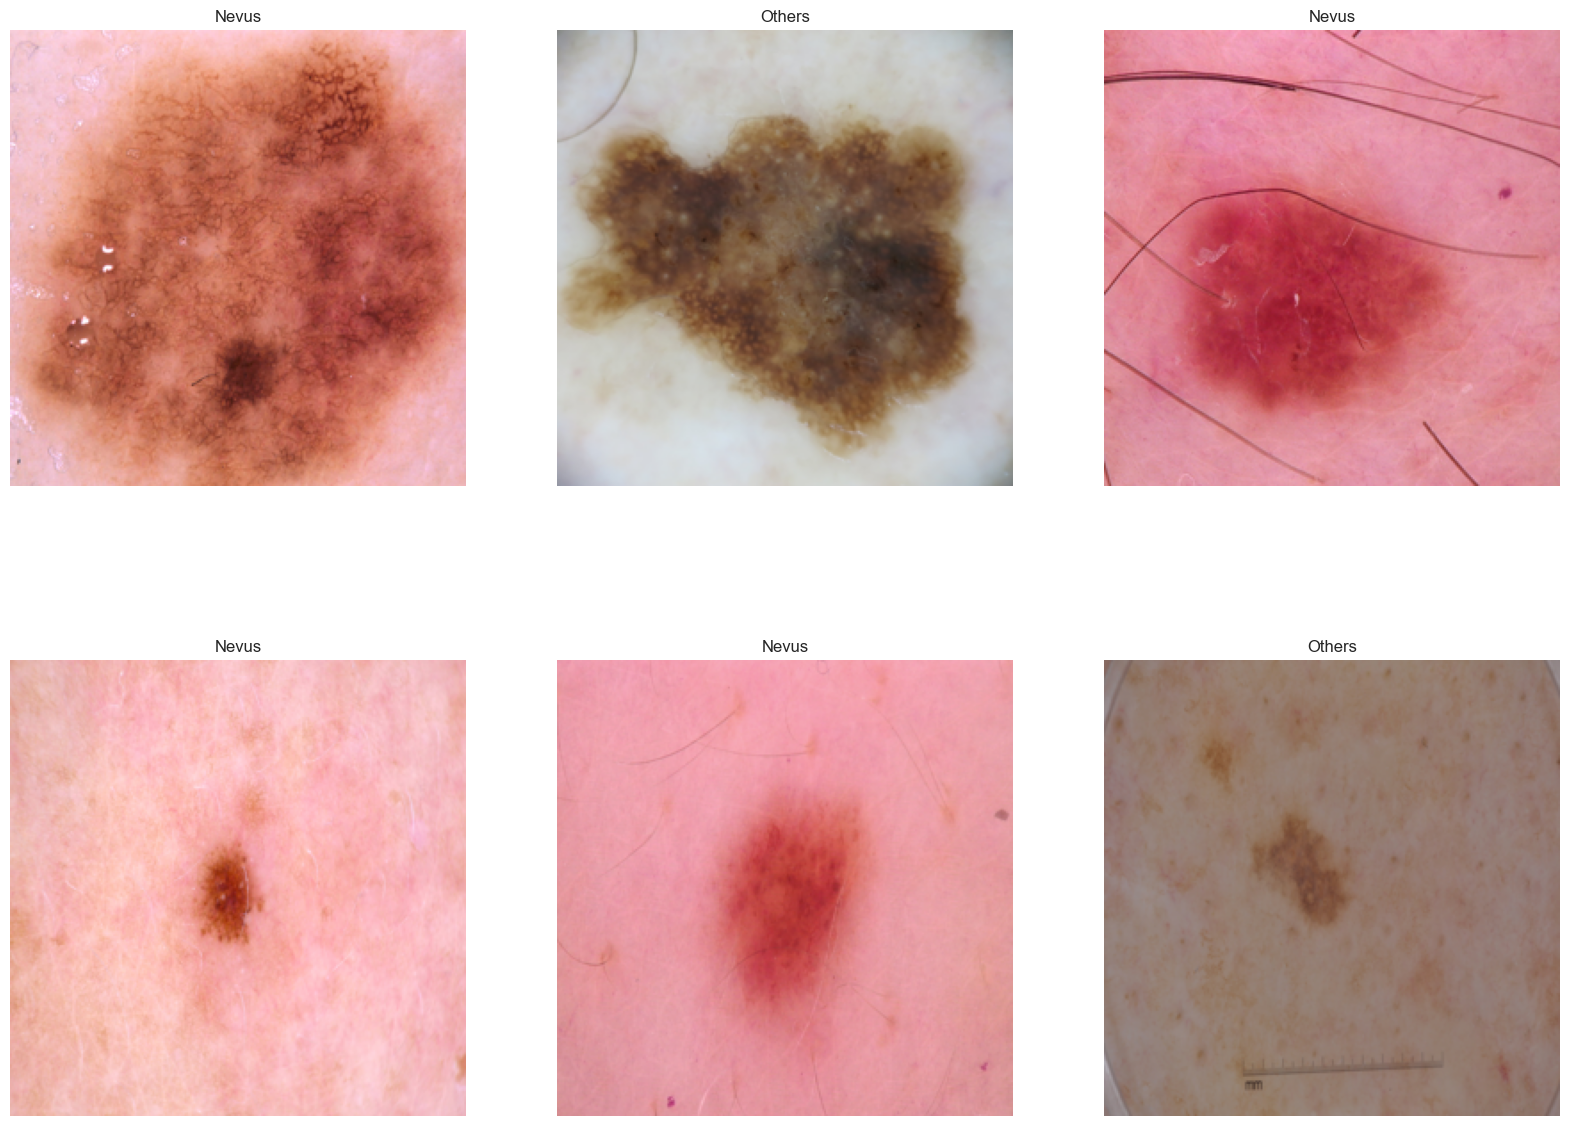

In [8]:
# Set the seaborn style
sns.set_style("white")

# Create a figure
plt.figure(figsize=[20, 15])

for i, (image_path, ground_truth) in enumerate(zip(tr_df["resized_images"][:6], tr_df["tr_gtruth"][:6])):
    # Set the title based on ground truth
    title = "Nevus" if ground_truth == 0 else "Others"
    
    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_path)
    plt.axis("off")
    plt.title(title)

plt.show()

In [11]:
intensity_features = pd.DataFrame()
intensity_features_list = []

glcm_features = pd.DataFrame()
glcm_features_list = []

lbp_features = pd.DataFrame()
lbp_features_list = []


for index, row in tr_df.iterrows():
    resized_image = row['resized_images']
    intensity_feature = extract_intensity_and_color_features(resized_image)
    intensity_features_list.append(pd.DataFrame(intensity_feature, index=[0]))
    glcm_feature = extract_glcm_features(resized_image)
    glcm_features_list.append(pd.DataFrame(glcm_feature, index=[0]))
    lbp_feature = extract_lbp_features(resized_image)
    lbp_features_list.append(pd.DataFrame(lbp_feature, index=[0]))

intensity_features = pd.concat(intensity_features_list, ignore_index=True)
glcm_features = pd.concat(glcm_features_list, ignore_index=True)
lbp_features = pd.concat(lbp_features_list, ignore_index=True)


# Combine intensity features with the original DataFrame
train_df = pd.concat([tr_df, intensity_features, glcm_features, lbp_features], axis=1)
train_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,...,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9
0,nev06032.jpg,train\nevus\nev06032.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,148.314468,58.666142,255,12,205.774139,126.807175,...,0.057739,0.075500,0.077499,0.129730,0.141830,0.125870,0.094589,0.081909,0.081314,0.134018
1,bkl00175.jpg,train\others\bkl00175.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,148.662384,57.879167,234,17,161.774139,148.098175,...,0.015808,0.034454,0.031311,0.148270,0.251022,0.230835,0.090652,0.061417,0.073364,0.062866
2,nev04056.jpg,train\nevus\nev04056.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,157.606176,51.807705,253,16,214.824936,121.644547,...,0.060013,0.080109,0.062500,0.102615,0.141342,0.123276,0.089157,0.088318,0.097748,0.154922
3,nev06830.jpg,train\nevus\nev06830.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,203.559926,35.346041,255,8,246.448441,183.095123,...,0.051773,0.080887,0.066589,0.114853,0.141357,0.130661,0.100937,0.084732,0.088867,0.139343
4,nev07645.jpg,train\nevus\nev07645.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,176.094294,44.354320,249,37,229.585648,145.228699,...,0.048355,0.078781,0.053757,0.101471,0.119507,0.126770,0.099014,0.093613,0.114578,0.164154


In [12]:
train_df.head()

,tr_img_name,tr_img_file,tr_gtruth,resized_images,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,...,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9
0,nev06032.jpg,train\nevus\nev06032.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,148.314468,58.666142,255,12,205.774139,126.807175,...,0.057739,0.075500,0.077499,0.129730,0.141830,0.125870,0.094589,0.081909,0.081314,0.134018
1,bkl00175.jpg,train\others\bkl00175.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,148.662384,57.879167,234,17,161.774139,148.098175,...,0.015808,0.034454,0.031311,0.148270,0.251022,0.230835,0.090652,0.061417,0.073364,0.062866
2,nev04056.jpg,train\nevus\nev04056.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,157.606176,51.807705,253,16,214.824936,121.644547,...,0.060013,0.080109,0.062500,0.102615,0.141342,0.123276,0.089157,0.088318,0.097748,0.154922
3,nev06830.jpg,train\nevus\nev06830.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,203.559926,35.346041,255,8,246.448441,183.095123,...,0.051773,0.080887,0.066589,0.114853,0.141357,0.130661,0.100937,0.084732,0.088867,0.139343
4,nev07645.jpg,train\nevus\nev07645.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,176.094294,44.354320,249,37,229.585648,145.228699,...,0.048355,0.078781,0.053757,0.101471,0.119507,0.126770,0.099014,0.093613,0.114578,0.164154


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15195 entries, 0 to 15194
Columns: 122 entries, tr_img_name to lbp_9
dtypes: float64(110), int64(1), object(3), uint8(8)
memory usage: 13.3+ MB


In [14]:
# Define file path for validation set
val_dir_path = "val"
val_nevus = os.path.join(val_dir_path, "nevus")
val_others = os.path.join(val_dir_path, "others")

# Initialize lists to store validation data
val_image_names = []
val_image_files = []
val_gtruth = []

# For nevus images in the validation set (groundtruth = 0)
for nevus_img in tqdm(os.listdir(val_nevus), desc="Nevus"):
    val_image_names.append(nevus_img)
    val_image_files.append(os.path.join(val_nevus, nevus_img))
    val_gtruth.append(0)

# For others images in the validation set (groundtruth = 1)
for others_img in tqdm(os.listdir(val_others), desc="Others"):
    val_image_names.append(others_img)
    val_image_files.append(os.path.join(val_others, others_img))
    val_gtruth.append(1)

# Create a DataFrame for validation data
val_data = {"val_img_name": val_image_names, "val_img_file": val_image_files, "val_gtruth": val_gtruth}
val_df = pd.DataFrame(val_data)

# Shuffle the validation DataFrame
val_df = shuffle(val_df).reset_index(drop=True)

# Resize images for validation set
val_df['resized_images'] = val_df['val_img_file'].apply(load_and_resize_image)

# Display the first few rows of the validation DataFrame
val_df.head()

Others: 100%|██████████| 1865/1865 [00:00<00:00, 115845.88it/s]


,val_img_name,val_img_file,val_gtruth,resized_images
0,nev08621.jpg,val\nevus\nev08621.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
1,bcc02127.jpg,val\others\bcc02127.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
2,nev08683.jpg,val\nevus\nev08683.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,bcc02223.jpg,val\others\bcc02223.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
4,nev07832.jpg,val\nevus\nev07832.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...


In [15]:
val_intensity_features = pd.DataFrame()
val_intensity_features_list = []

val_glcm_features = pd.DataFrame()
val_glcm_features_list = []

val_lbp_features = pd.DataFrame()
val_lbp_features_list = []

for index, row in val_df.iterrows():
    val_resized_image = row['resized_images']
    intensity_val_feature = extract_intensity_and_color_features(val_resized_image)
    glcm_val_feature = extract_glcm_features(val_resized_image)
    lbp_val_feature = extract_lbp_features(val_resized_image)
    val_intensity_features_list.append(pd.DataFrame(intensity_val_feature, index=[0]))
    val_glcm_features_list.append(pd.DataFrame(glcm_val_feature, index=[0]))
    val_lbp_features_list.append(pd.DataFrame(lbp_val_feature, index=[0]))

val_intensity_features = pd.concat(val_intensity_features_list, ignore_index=True)
val_glcm_features = pd.concat(val_glcm_features_list, ignore_index=True)
val_lbp_features = pd.concat(val_lbp_features_list, ignore_index=True)

# Combine intensity features with the original DataFrame
validation_df = pd.concat([val_df, val_intensity_features, val_glcm_features, val_lbp_features], axis=1)
validation_df.head()

,val_img_name,val_img_file,val_gtruth,resized_images,mean_intensity,std_intensity,max_intensity,min_intensity,mean_r,mean_g,...,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9
0,nev08621.jpg,val\nevus\nev08621.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,148.808802,55.630326,246,17,212.061981,119.361938,...,0.044815,0.075455,0.059219,0.115311,0.151611,0.136276,0.097382,0.085770,0.093475,0.140686
1,bcc02127.jpg,val\others\bcc02127.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,127.352768,49.924449,203,0,156.849106,129.820496,...,0.025055,0.043564,0.050827,0.150101,0.254379,0.178238,0.082886,0.054916,0.076126,0.083908
2,nev08683.jpg,val\nevus\nev08683.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,186.303304,40.619321,236,35,215.428497,171.031586,...,0.028320,0.061996,0.044724,0.118774,0.201019,0.185852,0.091278,0.077728,0.083542,0.106766
3,bcc02223.jpg,val\others\bcc02223.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...,156.489822,52.137666,244,13,213.548889,129.533859,...,0.019058,0.040482,0.038712,0.141754,0.255249,0.206467,0.095093,0.060638,0.065567,0.076981
4,nev07832.jpg,val\nevus\nev07832.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...,189.763758,22.350915,242,26,213.712509,180.137665,...,0.040268,0.082367,0.046280,0.110626,0.170258,0.124557,0.075409,0.100952,0.098480,0.150803


In [16]:
train_features = train_df.drop(columns=['tr_img_name', 'tr_img_file', 'resized_images', 'tr_gtruth'])
train_labels = train_df['tr_gtruth']

validation_features = validation_df.drop(columns=['val_img_name', 'val_img_file', 'resized_images', 'val_gtruth'])
validation_labels = validation_df['val_gtruth']

In [31]:
# Define features and labels for training
X_train = train_features
y_train = train_labels

# Define features and labels for validation
X_val = validation_features
y_val = validation_labels

# Standardize the data
X_train_pca = StandardScaler().fit_transform(X_train)
X_val_pca = StandardScaler().fit_transform(X_val)

# # Display the first few rows of the standardized data
# print("Standardized Training Features:")
# pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

In [32]:
# print("\nStandardized Validation Features:")
# pd.DataFrame(X_val_scaled, columns=X_val.columns).head()

In [33]:
print(X_val.isnull().sum())

mean_intensity    0
std_intensity     0
max_intensity     0
min_intensity     0
mean_r            0
                 ..
lbp_5             0
lbp_6             0
lbp_7             0
lbp_8             0
lbp_9             0
Length: 118, dtype: int64


In [29]:
# # Apply PCA
# pca = PCA(n_components=100)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_val_pca = pca.fit_transform(X_val_scaled)

# # Display the first few rows of the PCA-transformed data
# print("PCA-transformed Training Features:")
# pd.DataFrame(X_train_pca).head()

PCA-transformed Training Features:


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-6.125987,4.613057,-3.291320,3.742588,-1.127379,-1.247976,-0.316352,0.287077,1.225886,-1.610864,...,0.007052,0.000837,-0.011308,0.003872,0.003468,-0.001098,-0.000578,-0.005183,0.003048,-0.005201
1,-0.198017,0.288933,-5.045687,-2.652556,1.891893,-1.057408,-1.292875,1.722704,0.066992,-0.371111,...,-0.002600,0.001216,0.005467,0.009702,0.002316,-0.001393,0.000023,0.000226,-0.003195,-0.001827
2,-4.280253,1.385296,0.716320,4.323940,-1.443196,1.001918,-0.430277,0.506862,-0.778201,0.461657,...,0.021364,-0.019802,-0.000619,0.015625,0.007574,0.009902,-0.002162,0.011355,-0.003595,0.010016
3,-4.612402,-2.115401,1.936512,3.794680,-0.078220,-2.974138,1.340850,0.832178,0.282600,1.204594,...,-0.001204,0.006971,-0.001179,0.002403,-0.003256,0.003472,0.001413,0.000427,-0.001385,-0.001079
4,-0.705485,-5.515072,0.722129,5.414828,0.384148,0.840024,-0.383168,0.084508,-0.996636,0.916835,...,0.008208,0.008016,-0.000720,0.000700,-0.000900,-0.001633,0.001604,0.001384,-0.002223,-0.000050


In [34]:
# Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
logreg_classifier = LogisticRegression(random_state=42)
adaboost_classifier = AdaBoostClassifier(random_state=42)
nb_classifier = GaussianNB()

# Combine classifiers in a dictionary
classifiers = {
    'Random Forest': rf_classifier,
    'SVM': svm_classifier,
    'k-NN': knn_classifier,
    'Logistic Regression': logreg_classifier,
    'AdaBoost': adaboost_classifier,
    'Naive Bayes': nb_classifier
}

# Perform 10-fold cross-validation and predictions for each classifier
for clf_name, clf in classifiers.items():
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_results = cross_val_score(clf, X_train_pca, y_train, cv=skf)
    
    # Print cross-validation results
    print(f"\nClassifier: {clf_name}")
    print("Cross-validation Results:", cv_results)
    print("Average Cross-validation Accuracy:", np.mean(cv_results))
    
    # Fit the model on the entire training set (no need for additional scaling)
    clf.fit(X_train_pca, y_train)
    
    # Make predictions on the validation set
    y_pred_val = clf.predict(X_val_pca)
    
    # Evaluate the model
    acc_train = accuracy_score(y_train, clf.predict(X_train_pca))
    acc_val = accuracy_score(y_val, y_pred_val)
    
    print("\nEvaluation on Validation Set:")
    print("Training Accuracy:", acc_train)
    print("Validation Accuracy:", acc_val)
    
    # Print confusion matrix for validation set
    print("\nConfusion Matrix (Validation Set):")
    print(confusion_matrix(y_val, y_pred_val))
    
    # Print classification report for validation set
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_pred_val))


Classifier: Random Forest
Cross-validation Results: [0.81118421 0.79210526 0.78881579 0.81842105 0.79736842 0.80710994
 0.78867676 0.80052666 0.81040158 0.80118499]
Average Cross-validation Accuracy: 0.8015794671009321

Evaluation on Validation Set:
Training Accuracy: 1.0
Validation Accuracy: 0.8124341412012644

Confusion Matrix (Validation Set):
[[1583  348]
 [ 364 1501]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1931
           1       0.81      0.80      0.81      1865

    accuracy                           0.81      3796
   macro avg       0.81      0.81      0.81      3796
weighted avg       0.81      0.81      0.81      3796


Classifier: SVM
Cross-validation Results: [0.79407895 0.78289474 0.78684211 0.80263158 0.79013158 0.79526004
 0.78604345 0.78077683 0.8038183  0.79460171]
Average Cross-validation Accuracy: 0.7917079276532345

Evaluation on Validation Set:
Training Accur

C:\Users\sulei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sulei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Classifier: Logistic Regression
Cross-validation Results: [0.78289474 0.75460526 0.76842105 0.75789474 0.76052632 0.76629361
 0.7564187  0.76431863 0.77682686 0.78077683]
Average Cross-validation Accuracy: 0.7668976733307924


C:\Users\sulei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluation on Validation Set:
Training Accuracy: 0.7693320171108917
Validation Accuracy: 0.7708113804004215

Confusion Matrix (Validation Set):
[[1467  464]
 [ 406 1459]]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1931
           1       0.76      0.78      0.77      1865

    accuracy                           0.77      3796
   macro avg       0.77      0.77      0.77      3796
weighted avg       0.77      0.77      0.77      3796


Classifier: AdaBoost
Cross-validation Results: [0.77631579 0.74078947 0.74736842 0.77039474 0.75657895 0.78275181
 0.74391047 0.77221856 0.76036866 0.75049375]
Average Cross-validation Accuracy: 0.7601190620560618

Evaluation on Validation Set:
Training Accuracy: 0.7747285291214215
Validation Accuracy: 0.7642255005268704

Confusion Matrix (Validation Set):
[[1485  446]
 [ 449 1416]]

Classification Report (Validation Set):
              precision    recal